Part IV Project - H-DenseUNet CNN Implementation for Automated Segmentation of MRI Scans

In [8]:
#Libraries
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import os
import cv2
import time
from random import randint
import plotly.graph_objects as go

#CNN Libraries
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from keras.layers.core import Dropout
import tensorflow as tf

In [18]:
# %pip install opencv-python
# %pip install keras
# %pip install tensorflow==2.6
# %pip install --upgrade tensorflow
# %pip install protobuf==3.20.0
# %pip uninstall tensorflow
# %pip install tensorflow
# %pip install protobuf

Height and Width of Single MRI Scan:  (512, 512)


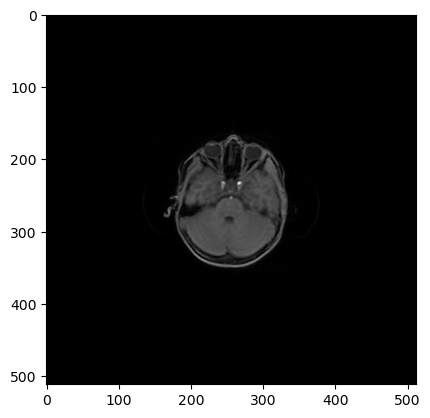

In [6]:
# Understanding the data format

# Read in Diacom file
example_mri_scan_file = pydicom.dcmread("/Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/MRI Scans - Tairawhiti/test_AutoBind_M3DLAVA_T1_2450/IM-0932-0093.dcm")
# pydicom.dcmread("C:/Users/GGPC/OneDrive/Desktop/Part 4 Project/Part4Project/MRI Scans - Tairawhiti/20Cen107_Tairawhiti_Test001_20Cen107_Tairawhiti_Test001/AutoBind_M3DLAVA_T1_2450/IM-0932-0093.dcm")
# Assessing metadata within Diacom file
example_mri_scan = example_mri_scan_file.pixel_array

print('Height and Width of Single MRI Scan: ', example_mri_scan.shape)

plt.imshow(example_mri_scan, cmap='gray')
plt.show()

Read In MRI Scan Data Procedure

In [7]:
# Read in entire scan of single patient
folders = [f for f in os.listdir('MRI Scans - Tairawhiti') if os.path.isdir(os.path.join('MRI Scans - Tairawhiti', f))]
def ListFolders(directory):
    folder_names = []
    for root, dirs, files in os.walk(directory):
        for folder in dirs:
            folder_names.append(folder)
    return folder_names

def read_dicom_files(directory):
    dicom_files = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath) and filename.endswith('.dcm'):
            try:
                dicom_file = pydicom.dcmread(filepath)
                dicom_files.append(dicom_file)
            except pydicom.errors.InvalidDicomError:
                print(f"Skipping file: {filename}. It is not a valid DICOM file.")
    return dicom_files

scans_path = '/Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/MRI Scans - Tairawhiti'
folders = ListFolders(scans_path)
scan_pixel_data = []

for paitent in folders:
    single_scan_pixel_data = []
    single_paitent_scans_path =  scans_path + '/{}'.format(paitent)
    dicom_files = read_dicom_files(single_paitent_scans_path)
    for i in range (len(dicom_files)):
        single_scan_pixel_data.append(dicom_files[i].pixel_array)
    scan_pixel_data.append(single_scan_pixel_data)

Preprocessing Phase

In [3]:
def IndividualScanVisualisation(scan):
    cv2.imshow('Modified MRI Image', scan)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imwrite('Modified MRI Image.png', scan)

In [5]:
def PreprocessingMRI(mri_scan_data):
    #Normalize image intensity (Image Normalization)
    start_time = time.time()
    img_norm = mri_scan_data.astype(np.float32) / 255.0
    print("Normalization time: %s seconds" % (time.time() - start_time))

    #Resize image to 256x256 from 512x512 (Image Resizing)
    start_time = time.time()
    img_resized = cv2.resize(img_norm, (256, 256))
    print("Resizing time: %s seconds" % (time.time() - start_time))

    #Crop image to remove irrelevant information (Image cropping)
    start_time = time.time()
    img_cropped = img_resized[50:200, 50:200]
    print("Cropping time: %s seconds" % (time.time() - start_time))

    #Apply median filtering to remove noise (Image Filtering - Noise Reduction)
    start_time = time.time()
    img_filtered = cv2.medianBlur(img_cropped, 1)
    print("Filtering time: %s seconds" % (time.time() - start_time))

    return img_filtered

Data Augmentation

In [6]:
def ImageDataAugmentation(img, num_augmentations):
    augmented_images = []

    for i in range(num_augmentations):
        
        #Apply a random rotation to the image
        angle = randint(-15, 15)
        M = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), angle, 1)
        rotated_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

        #Apply a random scaling to the image
        scale = randint(80, 120) / 100.0
        scaled_img = cv2.resize(rotated_img, None, fx=scale, fy=scale)

        #Apply a random horizontal flip to the image
        if randint(0, 1):
            flipped_img = cv2.flip(scaled_img, 1)
        else:
            flipped_img = scaled_img

        #Append the augmented image to the list
        augmented_images.append(flipped_img)

    #Convert the list of augmented images to a NumPy array
    augmented_images = np.array(augmented_images)

    return augmented_images

Splitting Dataset

In [7]:
def SplitDataset(pixel_data, train_pct, val_pct, test_pct):
    #Calculate the number of slices for each set
    num_slices = pixel_data.shape[0]
    num_train = int(num_slices * train_pct)
    num_val = int(num_slices * val_pct)
    num_test = num_slices - num_train - num_val

    #Shuffle the indices
    indices = np.random.permutation(num_slices)

    #Split the indices into sets
    train_indices = indices[:num_train]

    val_indices = indices[num_train:num_train+num_val]
    test_indices = indices[num_train+num_val:]

    #Split the data into sets
    train_data = pixel_data[train_indices]
    val_data = pixel_data[val_indices]
    test_data = pixel_data[test_indices]

    return train_data, val_data, test_data

Model

In [25]:
# def H_DenseUNet(input_shape=(256,256,1), n_classes=2, n_filters=16, dropout_rate=0.2):
#     # Input layer
#     inputs = Input(input_shape)

#     # Contracting path
#     c1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
#     c1 = BatchNormalization()(c1)
#     c1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(c1)
#     c1 = BatchNormalization()(c1)
#     p1 = MaxPooling2D((2, 2))(c1)

#     c2 = Conv2D(n_filters*2, (3, 3), activation='relu', padding='same')(p1)
#     c2 = BatchNormalization()(c2)
#     c2 = Conv2D(n_filters*2, (3, 3), activation='relu', padding='same')(c2)
#     c2 = BatchNormalization()(c2)
#     p2 = MaxPooling2D((2, 2))(c2)

#     c3 = Conv2D(n_filters*4, (3, 3), activation='relu', padding='same')(p2)
#     c3 = BatchNormalization()(c3)
#     c3 = Conv2D(n_filters*4, (3, 3), activation='relu', padding='same')(c3)
#     c3 = BatchNormalization()(c3)
#     p3 = MaxPooling2D((2, 2))(c3)

#     # Dense block
#     d1 = Conv2D(n_filters*8, (3, 3), activation='relu', padding='same')(p3)
#     d1 = BatchNormalization()(d1)
#     d1 = concatenate([p3, d1])
#     d1 = Conv2D(n_filters*8, (3, 3), activation='relu', padding='same')(d1)
#     d1 = BatchNormalization()(d1)
#     d1 = concatenate([p3, d1])
#     d1 = Conv2D(n_filters*8, (3, 3), activation='relu', padding='same')(d1)
#     d1 = BatchNormalization()(d1)
#     d1 = concatenate([p3, d1])
#     d1 = Conv2D(n_filters*8, (3, 3), activation='relu', padding='same')(d1)
#     d1 = BatchNormalization()(d1)

#     # Expanding path
#     u1 = UpSampling2D((2, 2))(d1)
#     u1 = concatenate([u1, c3])
#     c4 = Conv2D(n_filters*4, (3, 3), activation='relu', padding='same')(u1)
#     c4 = BatchNormalization()(c4)

In [34]:
# Model Architecture

def dense_block(input_tensor, filters, num_layers):
    x = input_tensor
    concat_layers = [x]

    for _ in range(num_layers):
        x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        concat_layers.append(x)
        x = Concatenate(axis=-1)(concat_layers)

    return x

def H_DenseUNet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoding Pathway
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = dense_block(pool1, 64, 4)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = dense_block(pool2, 128, 4)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = dense_block(pool3, 256, 4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Decoding Pathway
    up5 = Conv2D(128, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv4))
    merge5 = Concatenate(axis=-1)([conv3, up5])
    conv5 = dense_block(merge5, 256, 4)

    up6 = Conv2D(64, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = Concatenate(axis=-1)([conv2, up6])
    conv6 = dense_block(merge6, 128, 4)

    up7 = Conv2D(32, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = Concatenate(axis=-1)([conv1, up7])
    conv7 = dense_block(merge7, 64, 4)

    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=outputs)

    return model

Loss Function and Metrics

In [37]:
def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    union = tf.reduce_sum(y_true, axis=(1, 2, 3)) + tf.reduce_sum(y_pred, axis=(1, 2, 3))
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return (tf.reduce_mean(dice))

def dice_loss(y_true, y_pred):
    return (1.0 - dice_coefficient(y_true, y_pred))

Main

In [38]:
#Raw visualisation
#IndividualScanVisualisation()


# Preprocessing 

#individual_preprocessed_image_scan = PreprocessingMRI(example_mri_scan)
#augmented_image_scan = ImageDataAugmentation(individual_preprocessed_image_scan, num_augmentations = 10)
#train, validation, test = SplitDataset(augmented_image_scan, train_pct = 0.7, val_pct = 0.2, test_pct = 0.1)


# Model Architecture

# input_shape: Structure of input data and since we are using grayscale data 
# num_classes: Number of segmentation classes or categories (potentially requires tuning idk yet, but remains fixed for all layers)
# 1 - Background: Represents the background or non-limb regions.
# 2 - Femur: Represents the thigh bone.
# 3 - Tibia: Represents the shin bone.
# 4 - Fibula: Represents the smaller bone in the lower leg.
# 5 - Patella: Represents the kneecap.
# 6 - Muscles: Represents the muscles of the lower limb.
# 7 - Skin: Represents the skin covering the lower limb.
model = H_DenseUNet(input_shape = (256, 256, 1), num_classes = 7)
# H_DenseUNet(input_shape=(256,256,1), n_classes=2, n_filters=16, dropout_rate=0.2)


# Loss Function and Metrics

model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient])




# IndividualScanVisualisation(augmented_image_scan[0])

Normalization time: 0.002001047134399414 seconds
Resizing time: 0.0 seconds
Cropping time: 0.0 seconds
Filtering time: 0.0 seconds


C:\Users\GGPC\AppData\Local\Temp\ipykernel_20404\1859991533.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  augmented_images = np.array(augmented_images)
